In [102]:
import polars as pl
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import json

In [103]:
df_answers_1 = pl.read_csv("../answers/answers_1.csv")
df_answers_2 = pl.read_csv("../answers/answers_2.csv")


df_indiviudal_1 = pl.read_csv("../individuals/individuals_1.csv")
df_indiviudal_2 = pl.read_csv("../individuals/individuals_2.csv")


df_properties = pl.read_csv("../statementproperties/statementproperties_1.csv")

df_statements = pl.read_csv("../statements/statements_1.csv")

# 1. Concatenate the two DataFrames vertically
df_answers = pl.concat([df_answers_1, df_answers_2], how="vertical")

# 2. Concatenate the two DataFrames vertically
df_indiviudal = pl.concat([df_indiviudal_1, df_indiviudal_2], how="vertical")

In [104]:
df_answers.group_by("sessionId").agg(pl.count("sessionId").alias("count")).filter(
    pl.col("count") >= 15
)

sessionId,count
str,u32
"""bWukCfk67nJRm98AEcn1RPMukPzVeD…",15
"""CMzdcxCPc01IoXoUPg4PYTl9BYizyu…",15
"""fTHRz-PCkK6gaBrg5WQ-V85xEFCJSy…",15
"""Kv83niqmvDEw5jk-aBN9Xd1ZZczBCM…",15
"""3bBPi2_anGadGP9Gp78-ayPKn40eaE…",15
…,…
"""OSVqEdyNbFoYsh6dbbWcmjfu0n41Yw…",15
"""hgYo6xBeD811IAUHlBjip3y0A8RGLg…",15
"""Qo0mI8B50OT7GxlWCqzoAyiJYc9aHl…",15


In [105]:
df_answers = df_answers.with_columns(
    [pl.col("I_agree").cast(pl.Float64), pl.col("others_agree").cast(pl.Float64)]
)

df_answers.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null


In [106]:
df_median = df_answers.group_by("statementId").agg(
    pl.col("I_agree").median().alias("median_I_agree")
)

df_joined = df_answers.join(df_median, on="statementId", how="left")

df_joined = df_joined.with_columns(
    [
        (pl.col("I_agree") == pl.col("median_I_agree"))
        .cast(pl.Float64)
        .alias("is_consensus"),
        pl.when(pl.col("median_I_agree") == 0.5)
        .then(1.0)
        .otherwise(
            (pl.col("others_agree") == pl.col("median_I_agree")).cast(pl.Float64)
        )
        .alias("is_aware"),
    ]
)

df_joined.head(4)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0


In [107]:
df_joined

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0
5,0.0,"""I don't know""",0.0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:34""","""2023-06-14 17:11:34""",149,149,null,1.0,0.0,0.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
792554,1.0,"""It's obvious""",1.0,"""I think it's mostly a matter o…",1,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…","""2025-03-10 21:10:40""","""2025-03-10 21:10:40""",10000,10000,"""bbcd5d5""",1.0,1.0,1.0
792555,0.0,"""It's something I learned""",1.0,"""I don't know""",0,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…","""2025-03-10 21:11:08""","""2025-03-10 21:11:08""",9854,9854,"""bbcd5d5""",1.0,0.0,1.0
792556,1.0,"""It's obvious""",1.0,"""I don't know""",0,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…","""2025-03-10 21:11:20""","""2025-03-10 21:11:20""",9537,9537,"""bbcd5d5""",1.0,1.0,1.0


In [108]:
df_session = (
    df_joined.group_by("sessionId")
    .agg(
        [
            pl.col("is_consensus").mean().alias("consensus"),
            pl.col("is_aware").mean().alias("awareness"),
            pl.len().alias("response_count"),
        ]
    )
    .filter(pl.col("response_count") > 5)
    .with_columns(
        (pl.col("awareness") * pl.col("consensus")).sqrt().alias("commonsensicality")
    )
)

df_session = df_session.with_columns(
    ((pl.col("awareness") * pl.col("consensus")).sqrt()).alias("commonsensicality")
)

df_session

sessionId,consensus,awareness,response_count,commonsensicality
str,f64,f64,u32,f64
"""3KoJgd4aGwtspHr0wzGlJ2ZwVnS-TV…",0.928571,0.642857,14,0.772618
"""IBD_nT8bWMfeYlnp5gITdTINHqeH8T…",0.933333,0.933333,15,0.933333
"""EDSWrS2k08tSu0Cq3J2214YExkdaEQ…",0.857143,0.642857,14,0.742307
"""M8CjuBIPZDrOwhAZC1P8tCyrFXwF-A…",0.733333,0.8,15,0.765942
"""fRGgOL3SEU3vZcWLt1fkAmZZIjhIq_…",0.6,0.733333,15,0.663325
…,…,…,…,…
"""pkAwWjA4B4A0YPCny-7wHZErF9w2y6…",0.733333,0.666667,15,0.699206
"""wJ6DhRbOfNUtH-5ZHjT_H3nh1jiDRL…",0.933333,0.666667,15,0.788811
"""hUkTb1yiXRAQwz5ChXf5JjZdGzMpgn…",0.857143,0.714286,14,0.782461


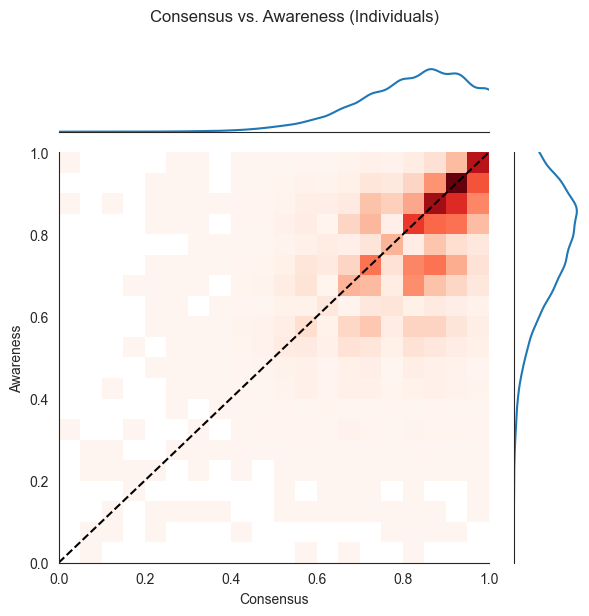

In [109]:
# json.loads(df_indiviudal[100].select("experimentInfo").to_numpy()[0][0])

df_pandas = df_session.to_pandas()

sns.set_style("white")

# Create an empty JointGrid
g = sns.JointGrid(data=df_pandas, x="consensus", y="awareness")

# Plot the 2D histogram in the center
g.plot_joint(sns.histplot, bins=20, cmap="Reds")

# Plot the marginals as line-based KDE curves
g.plot_marginals(
    sns.kdeplot,
    fill=False,        # no fill, just the line
    bw_adjust=2,     # increase bandwidth to smooth
    cut=0,             # don't extend the curve beyond the data
    clip=(0, 1)        # limit KDE to [0,1] (assuming consensus/awareness in [0,1])
)

# Add the reference diagonal
g.ax_joint.plot([0, 1], [0, 1], ls="--", color="black")

# Adjust axes and labels
g.ax_joint.set_xlim(0, 1)
g.ax_joint.set_ylim(0, 1)
g.set_axis_labels("Consensus", "Awareness")

# Title and layout
plt.suptitle("Consensus vs. Awareness (Individuals)", y=1.02)
plt.tight_layout()
plt.savefig("consensus_vs_awareness_individuals.pdf", dpi=300, bbox_inches="tight")

In [110]:
df_properties

id,name,available,createdAt,updatedAt,statementId
i64,str,i64,str,str,i64
1,"""behavior""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
2,"""everyday""",1,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
3,"""figure_of_speech""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
4,"""judgment""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
5,"""opinion""",0,"""2023-04-08 12:23:26""","""2023-04-08 12:23:26""",1
…,…,…,…,…,…
60656,"""everyday""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60657,"""figure_of_speech""",0,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859
60658,"""judgment""",1,"""2025-02-18 14:49:40""","""2025-02-18 14:49:40""",8859


In [111]:
properties_wide = df_properties.pivot(
    index="statementId",
    columns="name",
    values="available",
)

properties_wide

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_95342/1597815251.py:1: DeprecationWarning: The argument `columns` for `DataFrame.pivot` is deprecated. It has been renamed to `on`.
  properties_wide = df_properties.pivot(


statementId,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,i64,i64,i64,i64,i64,i64
1,0,1,0,0,0,1
2,0,0,0,0,0,0
3,1,1,0,1,0,1
4,0,1,0,0,0,0
5,0,1,0,1,1,0
…,…,…,…,…,…,…
8855,1,1,0,1,1,1
8856,1,1,0,1,1,1
8857,1,1,0,1,1,1


In [112]:
joined_answer_df = df_joined.join(
    properties_wide, 
    on="statementId",   
    how="inner"         
)

joined_answer_df

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0,0,0,1,1,0,1
5,0.0,"""I don't know""",0.0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:34""","""2023-06-14 17:11:34""",149,149,null,1.0,0.0,0.0,0,0,1,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
792554,1.0,"""It's obvious""",1.0,"""I think it's mostly a matter o…",1,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…","""2025-03-10 21:10:40""","""2025-03-10 21:10:40""",10000,10000,"""bbcd5d5""",1.0,1.0,1.0,0,1,0,0,0,0
792555,0.0,"""It's something I learned""",1.0,"""I don't know""",0,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…","""2025-03-10 21:11:08""","""2025-03-10 21:11:08""",9854,9854,"""bbcd5d5""",1.0,0.0,1.0,0,1,0,0,0,0
792556,1.0,"""It's obvious""",1.0,"""I don't know""",0,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…","""2025-03-10 21:11:20""","""2025-03-10 21:11:20""",9537,9537,"""bbcd5d5""",1.0,1.0,1.0,0,1,0,0,0,0


In [113]:
medians_means = (
    joined_answer_df
    .group_by("statementId")
    .agg([
        pl.col("I_agree").median().alias("median_i_agree"),
        pl.col("I_agree").mean().alias("mean_i_agree"),
    ])
)

medians_means.head(3)

statementId,median_i_agree,mean_i_agree
i64,f64,f64
10108,1.0,0.821429
1185,0.0,0.052632
1456,0.0,0.164948


In [114]:
answers_with_medians = joined_answer_df.join(medians_means, on="statementId")
answers_with_medians.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517


In [115]:
answers_with_awareness = answers_with_medians.with_columns(
    pl.when(pl.col("median_i_agree") == 0.5)
    .then(pl.lit(1.0))
    .otherwise((pl.col("others_agree") == pl.col("median_i_agree")).cast(pl.Float64()))
    .alias("awareness_row")
)

In [116]:
answers_with_awareness.head(3)

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,median_i_agree,mean_i_agree,awareness_row
i64,f64,str,f64,str,i64,str,str,str,str,str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,f64,f64,f64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1,1.0,0.965517,1.0


In [117]:
statement_commonsense = (
    answers_with_awareness.group_by("statementId")
    .agg(
        [
            pl.col("awareness_row").mean().alias("statement_awareness"),
            pl.col("mean_i_agree").mean().alias("mean_of_mean_i_agree"),
        ]
    )
    .with_columns(
        [(2 * (pl.col("mean_of_mean_i_agree") - 0.5).abs()).alias("statement_consensus")]
    )
    .with_columns(
        [
            (pl.col("statement_awareness") * pl.col("statement_consensus"))
            .sqrt()
            .alias("actual_commonsensicality")
        ]
    )
    .select(["statementId", "statement_awareness", "statement_consensus", "actual_commonsensicality"])
)

In [118]:
statement_commonsense

statementId,statement_awareness,statement_consensus,actual_commonsensicality
i64,f64,f64,f64
2239,0.778846,0.846154,0.811803
2918,1.0,1.0,1.0
3945,0.75,0.5,0.612372
1325,0.506849,0.150685,0.276359
9441,0.880952,0.904762,0.892778
…,…,…,…
9566,0.783133,0.855422,0.818479
9688,0.833333,0.714286,0.771517
777,0.75,0.5,0.612372


In [119]:
statement_commonsensicality_with_properties = statement_commonsense.join(properties_wide, on="statementId", how="left")

# statement_commonsensicality_with_properties

In [120]:
statement_commonsensicality_with_properties

statementId,statement_awareness,statement_consensus,actual_commonsensicality,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,f64,f64,i64,i64,i64,i64,i64,i64
2239,0.778846,0.846154,0.811803,0,0,0,0,0,0
2918,1.0,1.0,1.0,1,1,0,1,1,0
3945,0.75,0.5,0.612372,1,0,0,1,1,1
1325,0.506849,0.150685,0.276359,1,1,0,1,1,1
9441,0.880952,0.904762,0.892778,0,1,0,1,0,0
…,…,…,…,…,…,…,…,…,…
9566,0.783133,0.855422,0.818479,0,1,0,1,0,0
9688,0.833333,0.714286,0.771517,0,1,0,0,0,0
777,0.75,0.5,0.612372,0,1,0,1,0,0


In [121]:
long_df = statement_commonsensicality_with_properties.melt(
    id_vars=["statementId", "actual_commonsensicality"],
    value_vars=[
        "behavior",
        "everyday",
        "figure_of_speech",
        "judgment",
        "opinion",
        "reasoning",
    ],
    variable_name="property_name",
    value_name="has_property",
)



/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_95342/1703217166.py:1: DeprecationWarning: `DataFrame.melt` is deprecated. Use `unpivot` instead, with `index` instead of `id_vars` and `on` instead of `value_vars`
  long_df = statement_commonsensicality_with_properties.melt(


In [122]:
import numpy as np

boot_res = []

n_boot = 500
prop_list = [
    "behavior",
    "everyday",
    "figure_of_speech",
    "judgment",
    "opinion",
    "reasoning",
]

for prop in prop_list:

    true_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 1)
    )["actual_commonsensicality"].to_numpy()
    false_vals = long_df.filter(
        (pl.col("property_name") == prop) & (pl.col("has_property") == 0)
    )["actual_commonsensicality"].to_numpy()

    nT = len(true_vals)
    nF = len(false_vals)
    for _ in range(n_boot):
        sample_T = np.random.choice(true_vals, size=nT, replace=True)
        sample_F = np.random.choice(false_vals, size=nF, replace=True)
        mean_diff = sample_T.mean() - sample_F.mean()
        boot_res.append((prop, mean_diff))


boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])

/var/folders/5j/9pnb21r14qjbflhqq7gq72lr0000gn/T/ipykernel_95342/3102902135.py:33: DataOrientationWarning: Row orientation inferred during DataFrame construction. Explicitly specify the orientation by passing `orient="row"` to silence this warning.
  boot_df = pl.DataFrame(boot_res, schema=["property_name", "difference_mean"])


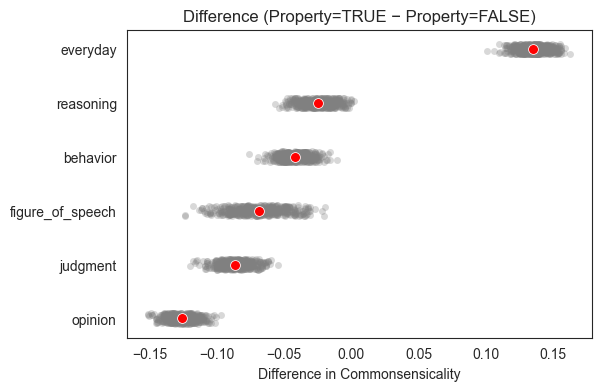

In [123]:
mean_diffs = (
    boot_df.group_by("property_name")
    .agg(pl.col("difference_mean").mean().alias("mean_diff"))
    .sort("mean_diff", descending=True)
)

mean_df_pd = mean_diffs.to_pandas()

cat_order = mean_df_pd["property_name"].tolist()


plt.figure(figsize=(6, 4))


sns.stripplot(
    data=boot_df.to_pandas(),
    x="difference_mean",
    y="property_name",
    alpha=0.3,
    color="gray",
    order=cat_order,
)

sns.scatterplot(
    data=mean_df_pd,
    x="mean_diff",
    y="property_name",
    color="red",
    s=50,
    zorder=10,
    hue_order=cat_order,
)


plt.xlabel("Difference in Commonsensicality")
plt.ylabel("")
plt.title("Difference (Property=TRUE − Property=FALSE)")
plt.show()

In [124]:
statement_commonsensicality_with_properties

statementId,statement_awareness,statement_consensus,actual_commonsensicality,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,f64,f64,i64,i64,i64,i64,i64,i64
2239,0.778846,0.846154,0.811803,0,0,0,0,0,0
2918,1.0,1.0,1.0,1,1,0,1,1,0
3945,0.75,0.5,0.612372,1,0,0,1,1,1
1325,0.506849,0.150685,0.276359,1,1,0,1,1,1
9441,0.880952,0.904762,0.892778,0,1,0,1,0,0
…,…,…,…,…,…,…,…,…,…
9566,0.783133,0.855422,0.818479,0,1,0,1,0,0
9688,0.833333,0.714286,0.771517,0,1,0,0,0,0
777,0.75,0.5,0.612372,0,1,0,1,0,0


In [125]:
category_plot_df = statement_commonsensicality_with_properties.join(
    df_statements, left_on="statementId", right_on="id", how="left"
)

In [126]:
category_means = (
    category_plot_df.group_by("statementCategory")
    .agg([pl.col("actual_commonsensicality").mean().alias("mean_commonsensicality")])
    .sort("mean_commonsensicality",descending=True)
)


cat_means_pd = category_means.to_pandas()
cat_order = cat_means_pd["statementCategory"].tolist()

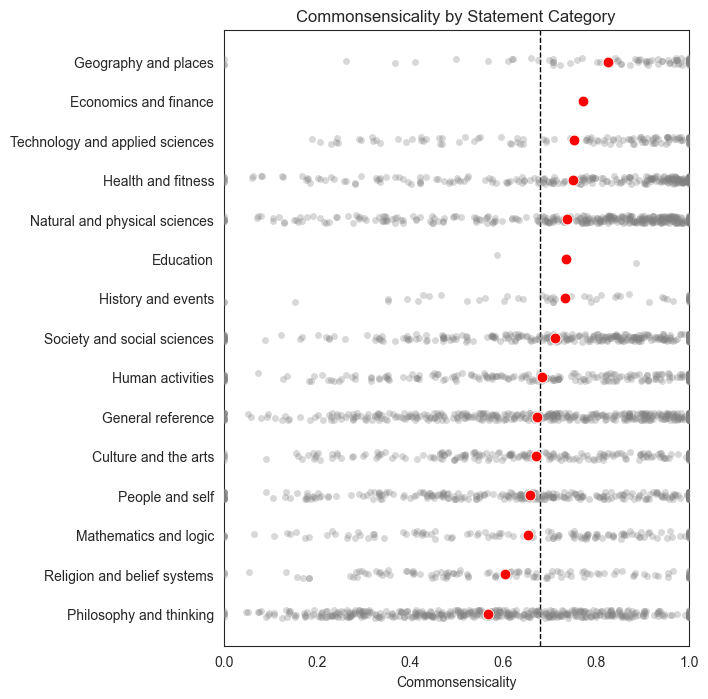

In [127]:
plot_df_pd = category_plot_df.to_pandas()

plt.figure(figsize=(6, 8))


ax = sns.stripplot(
    data=plot_df_pd,
    x="actual_commonsensicality",
    y="statementCategory",
    order=cat_order,
    alpha=0.3,
    color="gray",
    jitter=True,
)


mean_points_pd = cat_means_pd.rename(columns={"mean_commonsensicality": "x"})
sns.scatterplot(
    data=mean_points_pd,
    x="x",
    y="statementCategory",
    hue_order=cat_order,
    color="red",
    s=60,
    zorder=10,
    ax=ax,
)


overall_mean = plot_df_pd["actual_commonsensicality"].mean()

plt.axvline(x=overall_mean, color="black", linestyle="--", linewidth=1)

plt.xlim(0, 1)
plt.xlabel("Commonsensicality")
plt.ylabel("")
plt.title("Commonsensicality by Statement Category")
plt.show()

## Design point average commonsensicality

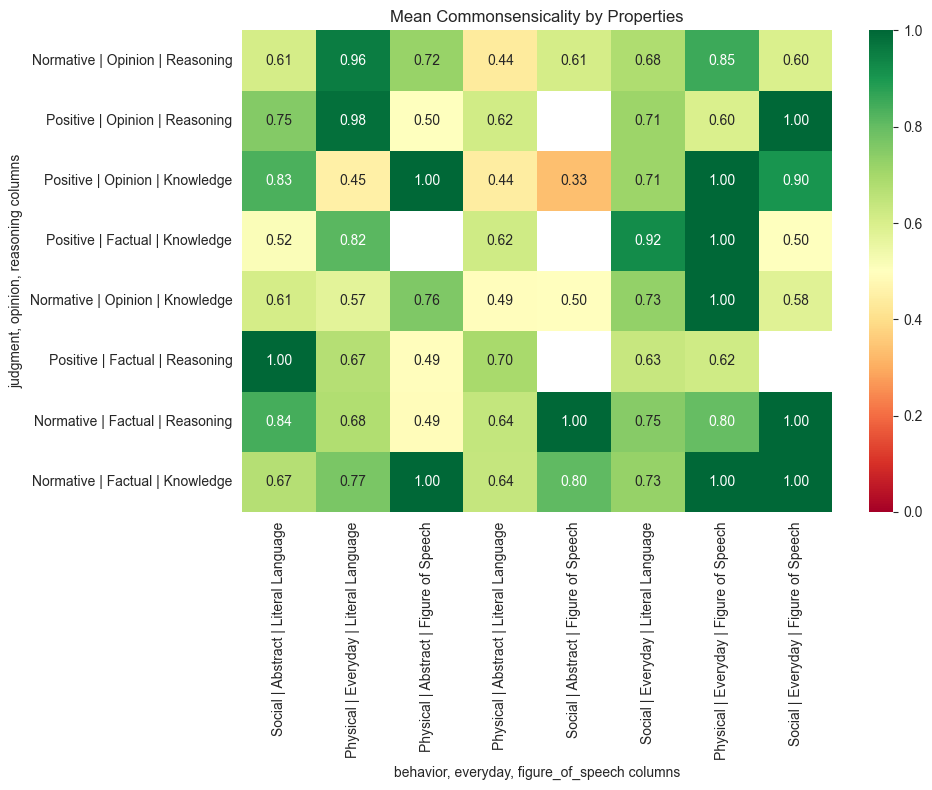

In [128]:
replace_dict = {
    "behavior": {"Physical": 0, "Social": 1},
    "everyday": {"Abstract": 0, "Everyday": 1},
    "figure_of_speech": {"Literal Language": 0, "Figure of Speech": 1},
    "judgment": {"Positive": 0, "Normative": 1},
    "opinion": {"Factual": 0, "Opinion": 1},
    "reasoning": {"Knowledge": 0, "Reasoning": 1},
}
inv_replace_dict = {
    col: {v: k for k, v in mapping.items()} for col, mapping in replace_dict.items()
}


df_replaced = statement_commonsensicality_with_properties

for col in inv_replace_dict.keys():
    df_replaced = df_replaced.with_columns(
        pl.col(col)
        .map_elements(
            lambda x: inv_replace_dict[col].get(x, f"Unmapped_{x}"),
            return_dtype=pl.String,
        )
        .alias(col)
    )

df_with_labels = df_replaced.with_columns(
    [
        pl.format(
            "{} | {} | {}",
            pl.col("behavior"),
            pl.col("everyday"),
            pl.col("figure_of_speech"),
        ).alias("x_label"),
        pl.format(
            "{} | {} | {}", pl.col("judgment"), pl.col("opinion"), pl.col("reasoning")
        ).alias("y_label"),
    ]
)

df_heat = (
    df_with_labels.group_by(["x_label", "y_label"])
    .agg([pl.col("actual_commonsensicality").mean().alias("avg_commonsensicality")])
    .pivot(
        index="y_label",
        on="x_label",
        values="avg_commonsensicality",
    )
)

df_heat_pd = df_heat.to_pandas()


df_heat_pd = df_heat_pd.set_index("y_label")

plt.figure(figsize=(10, 8))

sns.heatmap(
    df_heat_pd,
    cmap="RdYlGn",
    vmin=0,
    vmax=1,
    annot=True,
    fmt=".2f",
)

plt.title("Mean Commonsensicality by Properties")
plt.xlabel("behavior, everyday, figure_of_speech columns")
plt.ylabel("judgment, opinion, reasoning columns")
plt.tight_layout()
plt.show()

In [129]:
df_indiviudal

id,userSessionId,informationType,experimentInfo,urlParams,finished,createdAt,updatedAt
i64,str,str,str,str,i64,str,str
1,"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""CRT""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-04-23 17:48:36""","""2024-04-23 17:48:36"""
2,"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""rmeTen""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-04-23 17:49:01""","""2024-04-23 17:49:01"""
3,"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""demographics""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-04-23 17:49:41""","""2024-04-23 17:49:41"""
4,"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""CRT""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-05-29 17:56:59""","""2024-05-29 17:56:59"""
5,"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""rmeTen""","""{""surveySource"":""@watts-lab/su…",null,1,"""2024-05-29 17:57:14""","""2024-05-29 17:57:14"""
…,…,…,…,…,…,…,…
125047,"""HsYyIocP1IuJZBaJEMkg0T58SZfjrQ…","""rmeTen""","""{""surveySource"":""@watts-lab/su…",null,1,"""2025-03-09 21:08:57""","""2025-03-09 21:08:57"""
125048,"""HsYyIocP1IuJZBaJEMkg0T58SZfjrQ…","""demographicsLongInternational""","""{""surveySource"":""@watts-lab/su…",null,1,"""2025-03-09 21:10:34""","""2025-03-09 21:10:34"""
125049,"""oXr4Xgi4p2n8wf58EKlNpFdAK0o1X3…","""CRT""","""{""surveySource"":""@watts-lab/su…",null,1,"""2025-03-10 00:22:43""","""2025-03-10 00:22:43"""


In [130]:
df_inidivial_pivoted = df_indiviudal.pivot(
    index="userSessionId",
    on="informationType",
    values="experimentInfo",
    aggregate_function="first"
)

df_inidivial_pivoted

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational
str,str,str,str,str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null
…,…,…,…,…
"""KUFLHApG-cmlf2L96cWTnnIUTKQ4wa…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""7BzvtLE7Nx-HYsz6sbF8hR_h9TCEhK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"
"""GJNIZ7VTzY6040GIBaY8gx6SAT7QJn…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…"


In [131]:
df_with_crt = df_indiviudal.pivot(
    index="userSessionId",
    on="informationType",
    values="createdAt",
    aggregate_function="first"
)

df_inidivial_pivoted = df_inidivial_pivoted.join(df_with_crt, on="userSessionId", how="inner")


In [132]:
df_inidivial_pivoted.filter(
    pl.col("demographics").is_not_null()
    & pl.col("demographicsLongInternational").is_null()
)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right
str,str,str,str,str,str,str,str,str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null
…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",null


In [133]:
df_inidivial_pivoted.filter(
    pl.col("demographics").is_null()
    & pl.col("demographicsLongInternational").is_not_null()
)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right
str,str,str,str,str,str,str,str,str
"""yUfJswvhfTgY5NDQfXpx7q_Vy7iPXX…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-17 18:03:50""","""2025-01-17 18:04:13""",null,"""2025-01-17 18:04:45"""
"""ZvL0KmZG99yXp5MAewAapBRK7Y6PoY…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-17 20:30:57""","""2025-01-17 20:32:45""",null,"""2025-01-17 20:34:41"""
"""Qt2_Z0v0DTTt6XZ9eMEAWWPRPTrZQb…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-19 11:13:09""","""2025-01-19 11:14:47""",null,"""2025-01-19 11:16:26"""
"""CranewGsPv_jk5SinY_dHzLCVFxYkY…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-19 20:04:15""","""2025-01-19 20:07:19""",null,"""2025-01-19 20:09:12"""
"""LpybvN9troXTId5wYSOiZygOp95h_G…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-01-19 22:04:56""","""2025-01-19 22:06:52""",null,"""2025-01-19 22:10:09"""
…,…,…,…,…,…,…,…,…
"""KUFLHApG-cmlf2L96cWTnnIUTKQ4wa…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-03-09 04:26:05""","""2025-03-09 04:26:44""",null,"""2025-03-09 04:27:35"""
"""7BzvtLE7Nx-HYsz6sbF8hR_h9TCEhK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-03-09 13:20:28""","""2025-03-09 13:21:43""",null,"""2025-03-09 13:22:30"""
"""GJNIZ7VTzY6040GIBaY8gx6SAT7QJn…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""{""surveySource"":""@watts-lab/su…","""2025-03-09 13:25:46""","""2025-03-09 13:28:16""",null,"""2025-03-09 13:29:25"""


## Commonsensicality by country

A figure that shows the statement commonsensicality by dimension for top countries where the users are from.

In [143]:
import ast

df_filtered = df_inidivial_pivoted.filter(
    pl.col("demographics").is_not_null()
    & pl.col("demographicsLongInternational").is_null()
)


df_with_crt = df_filtered.with_columns(
    [
        pl.col("CRT")
        .map_elements(
            lambda x: ast.literal_eval(x)["result"]["score"] if x is not None else None,
            return_dtype=pl.Float64,
        )
        .alias("crt_score"),
        pl.col("rmeTen")
        .map_elements(
            lambda x: ast.literal_eval(x)["result"]["score"] if x is not None else None,
            return_dtype=pl.Float64,
        )
        .alias("rmeTen_score"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("birth_year")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("birth_year"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("gender")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("gender"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("marital_status")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("marital_status"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("language_primary")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("language_primary"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("english_written")
                if x is not None
                else None
            ),
            return_dtype=pl.Int64,
        )
        .alias("english_written"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("english_spoken")
                if x is not None
                else None
            ),
            return_dtype=pl.Int64,
        )
        .alias("english_spoken"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("employment_status")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("employment_status"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("country_reside")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("country_reside"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("education_US")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("education_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("latin_US")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("latin_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("race_US")
                if x is not None
                else None
            ),
            return_dtype=pl.List(pl.String),
        )
        .alias("race_US"),
        pl.col("demographics")
        .map_elements(
            lambda x: (
                ast.literal_eval(x)["responses"].get("income_US")
                if x is not None
                else None
            ),
            return_dtype=pl.String,
        )
        .alias("income_US"),
        # time posted
        pl.col("CRT_right")
        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
        .alias("CRT_right_parsed"),
        # time elapsed
        pl.col("CRT")
        .map_elements(
            lambda x: ast.literal_eval(x).get("secondsElapsed") if x else None,
            return_dtype=pl.Float32,
        )
        .alias("secondsElapsed"),
    ]
)

df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999""",2024-04-23 17:48:36,16.542
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-29 17:56:59,1462.202026
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999""",2024-05-31 16:27:30,11.385
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-31 16:58:16,1483.790039
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null,0.0,8.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999""",2024-06-06 16:50:40,58.095001
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null,4.0,8.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2025-01-14 21:59:50,115.124001
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null,0.0,7.0,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999""",2025-01-15 01:06:37,259.226013
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",null,4.0,8.0,"""1957""","""female""","""Single Never Married""","""English""",5,5,"""Retired""","""United States""","""6""",null,"[""White""]","""$20,000-$29,999""",2025-01-15 01:21:04,285.39801

In [144]:
# replace item1 with Not mentioned
df_with_crt = df_with_crt.with_columns(
    pl.col("country_reside").str.replace("item1", "Other")
)

In [145]:
df_with_crt = df_with_crt.with_columns(
    [
        # Parse "CRT_right" as Polars Datetime
        pl.col("CRT_right")
        .str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S")
        .alias("CRT_right_parsed"),
        # Subtract secondsElapsed (in seconds) from CRT_right_parsed to get start_time
        (
            pl.col("CRT_right_parsed")
            - (pl.col("secondsElapsed") * 1000).cast(pl.Duration("ms"))
        ).alias("start_time"),
    ]
)

df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms]
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-04-23 17:48:36""","""2024-04-23 17:49:01""","""2024-04-23 17:49:41""",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999""",2024-04-23 17:48:36,16.542,2024-04-23 17:48:19.458
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-29 17:56:59""","""2024-05-29 17:57:14""","""2024-05-29 17:57:18""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-29 17:56:59,1462.202026,2024-05-29 17:32:36.798
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:27:30""","""2024-05-31 16:28:06""","""2024-05-31 16:29:07""",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999""",2024-05-31 16:27:30,11.385,2024-05-31 16:27:18.615
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-05-31 16:58:16""","""2024-05-31 16:58:25""","""2024-05-31 16:58:36""",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null,2024-05-31 16:58:16,1483.790039,2024-05-31 16:33:32.210
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-06 16:50:40""","""2024-06-06 16:51:13""","""2024-06-06 16:52:13""",null,0.0,8.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999""",2024-06-06 16:50:40,58.095001,2024-06-06 16:49:41.905
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-14 21:59:50""","""2025-01-14 22:01:16""","""2025-01-14 22:01:55""",null,4.0,8.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2025-01-14 21:59:50,115.124001,2025-01-14 21:57:54.876
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:06:37""","""2025-01-15 01:07:59""","""2025-01-15 01:08:57""",null,0.0,7.0,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999""",2025-01-15 01:06:37,259.226013,2025-01-15 01:02:17.774
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2025-01-15 01:21:04""","""2025-01-15 01:44:13""","""2025-01-15 01:46:13""",

In [ ]:
# for the ones we have correct sessionId do a histogram of the seconds

AttributeError: 'DataFrame' object has no attribute 'agg'

In [137]:
df_replaced = joined_answer_df.with_columns(
    pl.col("createdAt").str.strptime(pl.Datetime, "%Y-%m-%d %H:%M:%S").alias("createdAt")
)

df_replaced

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning
i64,f64,str,f64,str,i64,str,str,str,datetime[μs],str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64
1,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…",2023-06-14 17:11:11,"""2023-06-14 17:11:11""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
2,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…",2023-06-14 17:11:17,"""2023-06-14 17:11:17""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
3,1.0,"""It's something I learned""",1.0,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…",2023-06-14 17:11:23,"""2023-06-14 17:11:23""",6,6,null,1.0,1.0,1.0,0,1,0,0,1,1
4,1.0,"""It's obvious""",1.0,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…",2023-06-14 17:11:27,"""2023-06-14 17:11:27""",149,149,null,1.0,1.0,1.0,0,0,1,1,0,1
5,0.0,"""I don't know""",0.0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…",2023-06-14 17:11:34,"""2023-06-14 17:11:34""",149,149,null,1.0,0.0,0.0,0,0,1,1,0,1
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
792554,1.0,"""It's obvious""",1.0,"""I think it's mostly a matter o…",1,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…",2025-03-10 21:10:40,"""2025-03-10 21:10:40""",10000,10000,"""bbcd5d5""",1.0,1.0,1.0,0,1,0,0,0,0
792555,0.0,"""It's something I learned""",1.0,"""I don't know""",0,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…",2025-03-10 21:11:08,"""2025-03-10 21:11:08""",9854,9854,"""bbcd5d5""",1.0,0.0,1.0,0,1,0,0,0,0
792556,1.0,"""It's obvious""",1.0,"""I don't know""",0,null,"""en""","""Ad1cvE5mQQ4YIe7yBJud3LLbQC3ytG…",2025-03-10 21:11:20,"""2025-03-10 21:11:20""",9537,9537,"""bbcd5d5""",1.0,1.0,1.0,0,1,0,0,0,0


In [155]:
# find orphan sessionIds in df_with_crt ---
df_orphan = df_with_crt.join(
    df_replaced,
    left_on="userSessionId",
    right_on="sessionId",
    how="anti",  # "anti" join returns rows in df_with_crt that do NOT match
)

print(f"Number of orphan sessionIds: {len(df_orphan)} from {len(df_with_crt)}")

df_orphan = df_orphan.with_columns(
    pl.col("start_time")
    .dt.cast_time_unit("us")  # unify time unit
    .dt.round("1s")  # round to nearest second
    .alias("start_time_rounded")
)
df_orphan

Number of orphan sessionIds: 33965 from 40093


userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],datetime[μs]
"""Wjnp2MqDSWpR03ZKOqr6P-c4dpV0cl…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 05:38:28""","""2024-06-12 05:40:31""","""2024-06-12 05:41:13""",null,0.0,6.0,"""1990""","""male""","""Married or Domestic Partnershi…","""Hindi""",5,3,"""Self-employed""","""India""",null,null,[],null,2024-06-12 05:38:28,299.742004,2024-06-12 05:33:28.258,2024-06-12 05:33:28
"""ou8Jhm-v9vA6nXo01eaLWfhOQPpaDZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 11:37:55""","""2024-06-12 11:39:32""","""2024-06-12 11:40:11""",null,0.0,4.0,"""1966""","""male""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""India""",null,null,[],null,2024-06-12 11:37:55,134.386993,2024-06-12 11:35:40.613,2024-06-12 11:35:41
"""7zOA06R0Oes9di602JaKBp-xgd1632…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 12:14:50""","""2024-06-12 12:16:28""","""2024-06-12 12:17:24""",null,5.0,9.0,"""1984""","""female""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$40,000-$49,999""",2024-06-12 12:14:50,307.290985,2024-06-12 12:09:42.709,2024-06-12 12:09:43
"""htbaldHAHnJYbtnSrDLaCPyCMAQCcr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 08:27:13""","""2024-06-17 08:29:23""","""2024-06-17 08:30:36""",null,5.0,6.0,"""1993""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Self-employed""","""United States""","""6""","""No""","[""White""]","""$10,000-$19,999""",2024-06-17 08:27:13,916.80603,2024-06-17 08:11:56.194,2024-06-17 08:11:56
"""q4yFLO-WfM2JEzmKY2MTevO0MuhdbT…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 14:22:13""","""2024-06-17 14:23:14""","""2024-06-17 14:24:57""",null,2.0,8.0,"""2004""","""female""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""3""",null,"[""Asian""]","""$150,000 or more""",2024-06-17 14:22:13,118.037003,2024-06-17 14:20:14.963,2024-06-17 14:20:15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""sVFA85--Bak4ACO90X7ppXtQG-W_NU…",null,null,"""{""surveySource"":""@watts-lab/su…",null,null,null,"""2024-10-06 11:19:57""",null,null,null,"""1965""","""female""","""Separated""","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$75,000-$99,999""",null,null,null,null
"""ajMiS9P3NGyoMvwuomTA5XG6RRjf_P…",null,null,"""{""surveySource"":""@watts-lab/su…",null,null,null,"""2024-10-06 11:22:33""",null,null,null,"""1977""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United Kingdom""",null,null,[],null,null,null,null,null
"""96RFYxyrmulX-1Z-ENdDV_7qSqhATZ…",null,null,"""{""surveySource"":""@watts-lab/su…",null,null,null,"""2024-10-06 11:23:08""",null,null,null,"""1961""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Retired""","""United Kingdom""",null,null,[],null,null,null,null,null


In [158]:
df_answer_counts = df_replaced.group_by("sessionId").agg(
    [
        pl.len().alias("num_answers"),
        pl.max("createdAt").alias("latest_createdAt"),
    ]
)
df_answer_15 = df_answer_counts.filter(pl.col("num_answers") >= 15)

df_answer_15 = df_answer_15.with_columns(
    pl.col("latest_createdAt")
    .dt.cast_time_unit("us")
    .dt.round("1s")
    .alias("latest_createdAt")
)

df_answer_15

sessionId,num_answers,latest_createdAt
str,u32,datetime[μs]
"""THcgd4fk2UQPkhdgIU0KOxsXGJxKSB…",15,2024-09-30 23:46:13
"""BktTN5cnsSCo5H3EaDZ_9aoysq6j3E…",15,2024-09-30 21:59:08
"""cHduscbBOxAu5Amtoaexck81O9sTX8…",15,2024-09-30 21:01:29
"""87ijPv_C2j7GlFVDHvOMdH28VHcyJ2…",15,2024-10-02 06:29:14
"""ku_EWh-7ekU3NRfKzyrMJij1dCFWz_…",15,2024-10-03 16:19:38
…,…,…
"""vkGGSB8LEcGOXtm6Xfl6zAYFBfzDdy…",15,2024-10-05 16:01:02
"""4px66gL7rd9V0OUhZ6Ou94Vzm-i676…",15,2024-10-02 15:50:01
"""2h62Jeij8TG0elpua7oipF6CyK7yTD…",26,2024-12-16 08:58:07


In [160]:
df_possible_matches = df_orphan.join(
    df_answer_15,
    left_on="start_time_rounded",
    right_on="latest_createdAt",
    how="inner",
)

df_possible_matches

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,start_time_rounded,sessionId,num_answers
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],datetime[μs],str,u32
"""Wjnp2MqDSWpR03ZKOqr6P-c4dpV0cl…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 05:38:28""","""2024-06-12 05:40:31""","""2024-06-12 05:41:13""",null,0.0,6.0,"""1990""","""male""","""Married or Domestic Partnershi…","""Hindi""",5,3,"""Self-employed""","""India""",null,null,[],null,2024-06-12 05:38:28,299.742004,2024-06-12 05:33:28.258,2024-06-12 05:33:28,"""9KvtmL02Lk1tm4RfdZoY_ZhAG41lsH…",15
"""ou8Jhm-v9vA6nXo01eaLWfhOQPpaDZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-12 11:37:55""","""2024-06-12 11:39:32""","""2024-06-12 11:40:11""",null,0.0,4.0,"""1966""","""male""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""India""",null,null,[],null,2024-06-12 11:37:55,134.386993,2024-06-12 11:35:40.613,2024-06-12 11:35:41,"""Prt54z46eE3sCRgKRIn0_bQ9yeapkY…",15
"""htbaldHAHnJYbtnSrDLaCPyCMAQCcr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 08:27:13""","""2024-06-17 08:29:23""","""2024-06-17 08:30:36""",null,5.0,6.0,"""1993""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Self-employed""","""United States""","""6""","""No""","[""White""]","""$10,000-$19,999""",2024-06-17 08:27:13,916.80603,2024-06-17 08:11:56.194,2024-06-17 08:11:56,"""j83oA4arrNE7xJ3k0FwpGwVKODWSvD…",15
"""oCUaKJtMlYj5febbFt8kD_z0j-FK0y…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 03:04:57""","""2024-06-19 03:06:08""","""2024-06-19 03:06:52""",null,5.0,9.0,"""1981""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White"", ""Asian""]","""$50,000-$74,999""",2024-06-19 03:04:57,444.92099,2024-06-19 02:57:32.079,2024-06-19 02:57:32,"""XTyiQdxz-eYE_Bl7MME2jL1GZhSrri…",15
"""Wvesp4iHPkWb4m-ITT8qprklI0BbcF…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 03:55:54""","""2024-06-19 03:56:44""","""2024-06-19 03:57:09""",null,6.0,9.0,"""1994""","""female""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999""",2024-06-19 03:55:54,182.830002,2024-06-19 03:52:51.170,2024-06-19 03:52:51,"""nZrVHSyMGUBQEqFw8mFokPapoG3h7l…",15
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""fEmwzugltwymRlvglSDgqF6CGIDxWU…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-24 03:00:30""","""2024-06-24 03:01:17""","""2024-06-24 03:02:12""",null,2.0,8.0,"""1987""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""6""","""No""","[""White""]","""$100,000-$149,999""",2024-06-24 03:00:30,52.027,2024-06-24 02:59:37.973,2024-06-24 02:59:38,"""7Ql0mHSeLK4gpWN7Gfhe12nnjBLxS8…",15
"""Bq3QSsMKcVlwCpSTgW2pi57Clm9CUm…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-24 11:36:14""","""2024-06-24 11:41:20""","""2024-06-24 11:42:46""",null,3.0,7.0,"""1980""","""male

In [152]:
df_orphan.filter(pl.col("start_time") == pl.datetime(2024, 10, 7, 14, 7, 44))

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[μs]


In [140]:
df_answer_15.filter(pl.col("sessionId") == "kN51XnkgRm9Fexer5FQv3b0NdNqiRbmc")

sessionId,num_answers,latest_createdAt
str,u32,datetime[μs]
"""kN51XnkgRm9Fexer5FQv3b0NdNqiRb…",15,2024-10-07 14:07:44


In [141]:
df_commonsense_country_info = df_with_crt.join(
    df_session, left_on="userSessionId", right_on="sessionId", how='inner'
)
print(df_commonsense_country_info.shape)
df_commonsense_country_info

(6126, 30)


userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,consensus,awareness,response_count,commonsensicality
str,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],f64,f64,u32,f64
"""IBD_nT8bWMfeYlnp5gITdTINHqeH8T…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-17 17:31:41""","""2024-06-17 17:34:12""","""2024-06-17 17:35:08""",null,5.0,9.0,"""1965""","""female""","""Single Never Married""","""English""",5,5,"""Self-employed""","""United States""","""7""","""No""","[""White""]","""Less than $10,000""",2024-06-17 17:31:41,1157.926025,2024-06-17 17:12:23.074,0.933333,0.933333,15,0.933333
"""u1bg2uv9zEw4UXO_u1jufSRTsB0kUt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 12:58:51""","""2024-06-19 13:00:29""","""2024-06-19 13:01:08""",null,4.0,8.0,"""1982""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""4""","""Yes""","[""White""]","""$20,000-$29,999""",2024-06-19 12:58:51,454.723999,2024-06-19 12:51:16.276,0.666667,0.466667,15,0.557773
"""IBgiW5Z3qTRNElPCnTFf-vcPuljw4l…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-13 17:01:47""","""2024-06-13 17:03:54""","""2024-06-13 17:14:33""",null,2.0,8.0,"""1958""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""6""",null,"[""White""]","""$150,000 or more""",2024-06-13 17:01:47,603.880005,2024-06-13 16:51:43.120,0.733333,0.7,30,0.716473
"""OK9gpRoRs8FuA-w9MbPZamrtLalD1e…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-07 15:17:04""","""2024-11-07 15:20:39""","""2024-11-07 15:26:56""",null,6.0,9.0,"""1945""","""male""","""Married or Domestic Partnershi…","""English""",4,4,"""Retired""","""United Kingdom""",null,null,[],null,2024-11-07 15:17:04,896.005981,2024-11-07 15:02:07.994,0.933333,0.733333,15,0.827312
"""S3euv9Fz4QJGf3_s660CtO-RkDReTn…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-06-19 23:37:00""","""2024-06-19 23:37:43""","""2024-06-19 23:38:13""",null,0.0,7.0,"""1986""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""3""","""No""","[""White""]","""$75,000-$99,999""",2024-06-19 23:37:00,141.908005,2024-06-19 23:34:38.092,0.866667,0.8,15,0.832666
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""NhsD2BRyz3jkvjLIz8R3FgJga85ouR…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-12-09 00:37:38""","""2024-12-09 00:40:37""","""2024-12-09 00:41:41""",null,4.0,7.0,"""1965""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Unable to work""","""Canada""",null,null,[],null,2024-12-09 00:37:38,906.171997,2024-12-09 00:22:31.828,0.733333,0.6,15,0.663325
"""UvKp0wbeubuo2KPO1omic2OPE1C_do…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-10-11 06:31:04""","""2024-10-11 06:32:53""","""2024-10-11 06:34:45""",null,5.0,9.0,"""1972""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Self-employed""","""United Kingdom""",null,null,[],null,2024-10-11 06:31:04,499.106995,2024-10-11 06:22:44.893,0.866667,0.8,15,0.832666

In [142]:
df_commonsense_country_info.filter(pl.col("commonsensicality").is_null())[0].to_dicts()

IndexError: index 0 is out of bounds for DataFrame of height 0

In [ ]:
df_with_crt

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US
str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str
"""FkNLAgvZVY9w_7ZdMSlLg7FGlbuttt…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,4.0,"""1999""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""7""","""No""","[""White""]","""$100,000-$149,999"""
"""l4JyCjo2Mq0huM9-Z78JRvxO3bERBK…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null
"""ZT_ckkMnCIWKaeFQtEjEdiIpFjx2xk…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,3.0,"""1985""","""male""","""Married or Domestic Partnershi…","""Korean""",5,5,"""Out of work and looking for wo…","""United States""","""4""","""Yes""","[""Asian"", ""White""]","""$30,000-$39,999"""
"""VPgzPGNjKA4_OQ5VJvvEKyeoAe2DpZ…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,4.0,"""2000""","""female""","""Widowed""","""Arabic""",1,5,"""Unable to work""","""Bahamas""",null,null,[],null
"""wx2DpRTkgySjtK2a8sgKVRHV_hi-F7…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,8.0,"""1961""","""female""","""Divorced""","""English""",5,5,"""Employed for wages""","""United States""","""5""","""No""","[""White""]","""$50,000-$74,999"""
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
"""iyE8Q-Hq54GCMtOYlzBvUHfEAq_Oyr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,4.0,8.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""8""","""No""","[""White""]","""$100,000-$149,999"""
"""NvsQs6nVeQJQ42gDnTQnuWiJUVoRPs…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,7.0,"""1960""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United States""","""4""","""No""","[""White""]","""$75,000-$99,999"""
"""COQN5Y4-ppLuwdccoKWRqPFs6de7Yr…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,4.0,8.0,"""1957""","""female""","""Single Never Married""","""English""",5,5,"""Retired""","""United States""","""6""",null,"[""White""]","""$20,000-$29,999"""


In [ ]:
df_answers

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion
i64,i64,str,i64,str,i64,str,str,str,str,str,i64,i64,str
1,1,"""It's obvious""",1,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:11""","""2023-06-14 17:11:11""",6,6,null
2,1,"""It's something I learned""",1,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""siFSQa8F_h3woRq5maLEsmoDQmA-ws…","""2023-06-14 17:11:17""","""2023-06-14 17:11:17""",6,6,null
3,1,"""It's something I learned""",1,"""I think most people have good …",1,"""Clear: it is clearly written a…","""en""","""7A2Xy3lMfn_Pe12DeucuE-1swxAv34…","""2023-06-14 17:11:23""","""2023-06-14 17:11:23""",6,6,null
4,1,"""It's obvious""",1,"""I think most people lack good …",0,"""Clear: it is clearly written a…","""en""","""n4yeiqY8p1DDUmxhKphavobA-w5LCn…","""2023-06-14 17:11:27""","""2023-06-14 17:11:27""",149,149,null
5,0,"""I don't know""",0,"""I don't know""",0,"""Confusing: I don't quite under…","""en""","""uZBSJf5x8X7I1vvwiX4K7YfrB7hY_t…","""2023-06-14 17:11:34""","""2023-06-14 17:11:34""",149,149,null
…,…,…,…,…,…,…,…,…,…,…,…,…,…
790900,1,"""It's my opinion""",1,"""I think it's mostly a matter o…",1,null,"""en""","""Qp36HqYhUh4dsEz0026_AJeLM1Xb9m…","""2025-02-25 02:06:26""","""2025-02-25 02:06:26""",9236,9236,"""bbcd5d5"""
790901,1,"""I don't know""",1,"""I don't know""",0,null,"""en""","""Qp36HqYhUh4dsEz0026_AJeLM1Xb9m…","""2025-02-25 02:06:56""","""2025-02-25 02:06:56""",10019,10019,"""bbcd5d5"""
790902,1,"""It's my opinion""",1,"""I think it's mostly a matter o…",0,null,"""en""","""Qp36HqYhUh4dsEz0026_AJeLM1Xb9m…","""2025-02-25 02:07:16""","""2025-02-25 02:07:16""",9804,9804,"""bbcd5d5"""


In [ ]:
df_country_plot = df_commonsense_country_info.group_by("country_reside").agg(
    pl.col("commonsensicality").mean().alias("avg_commonsensicality")
)

In [176]:
df_replaced.join(
    df_commonsense_country_info,
    right_on="userSessionId",
    left_on="sessionId",
    how="left",
).filter(pl.col("country_reside").is_not_null())
# .group_by("country_reside").agg(
#     pl.col("commonsensicality").mean().alias("avg_commonsensicality"),
#     pl.col("sessionId").count().alias("count")
# )

id,I_agree,I_agree_reason,others_agree,others_agree_reason,perceived_commonsense,clarity,origLanguage,sessionId,createdAt,updatedAt,statement_number,statementId,clientVersion,median_I_agree,is_consensus,is_aware,behavior,everyday,figure_of_speech,judgment,opinion,reasoning,CRT,rmeTen,demographics,demographicsLongInternational,CRT_right,rmeTen_right,demographics_right,demographicsLongInternational_right,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,CRT_right_parsed,secondsElapsed,start_time,consensus,awareness,response_count,commonsensicality
i64,f64,str,f64,str,i64,str,str,str,datetime[μs],str,i64,i64,str,f64,f64,f64,i64,i64,i64,i64,i64,i64,str,str,str,str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,datetime[μs],f32,datetime[ms],f64,f64,u32,f64
3376,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:03,"""2023-07-18 09:33:03""",1653,1653,null,1.0,1.0,1.0,1,1,1,0,0,0,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,42.435001,2024-11-09 13:34:30.565,0.8,0.814286,70,0.807111
3377,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:11,"""2023-07-18 09:33:11""",806,806,null,1.0,1.0,1.0,1,1,0,1,0,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,42.435001,2024-11-09 13:34:30.565,0.8,0.814286,70,0.807111
3378,1.0,"""It's obvious""",1.0,"""I don't know""",0,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:50,"""2023-07-18 09:33:50""",4161,4161,null,1.0,1.0,1.0,1,1,0,0,1,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,42.435001,2024-11-09 13:34:30.565,0.8,0.814286,70,0.807111
3379,1.0,"""It's obvious""",1.0,"""I think most people have good …",0,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:33:55,"""2023-07-18 09:33:55""",831,831,null,1.0,1.0,1.0,0,1,0,0,0,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,42.435001,2024-11-09 13:34:30.565,0.8,0.814286,70,0.807111
3380,1.0,"""It's obvious""",1.0,"""I think most people have good …",1,null,"""en""","""nT7bs-XHJvtATColxhCUmKidpQZk0U…",2023-07-18 09:34:42,"""2023-07-18 09:34:42""",3794,3794,null,0.0,0.0,0.0,0,1,0,0,0,1,"""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,"""2024-11-09 13:35:13""","""2024-11-09 13:35:35""","""2024-11-09 13:35:49""",null,0.0,2.0,"""1990""","""female""","""Married or Domestic Partnershi…","""Gujarathi""",1,1,"""Self-employed""","""Belgium""",null,null,[],null,2024-11-09 13:35:13,42.435001,2024-

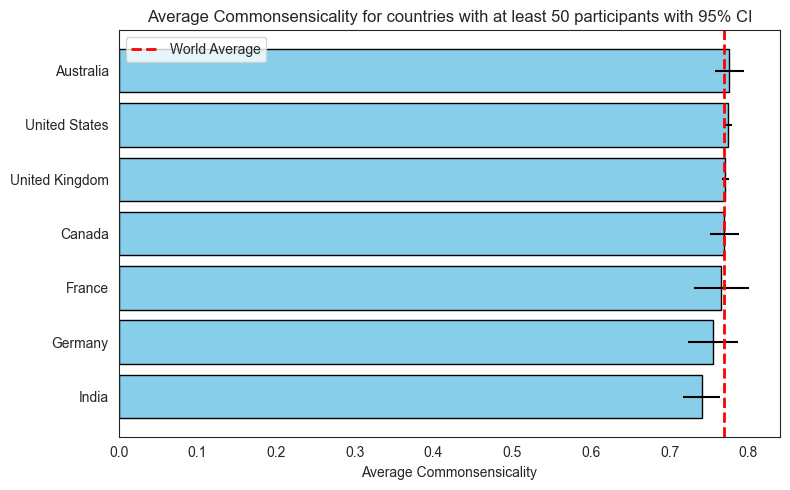

In [ ]:
pandas_df_commonsense_country_info = df_commonsense_country_info.to_pandas()

world_avg = df_commonsense_country_info["commonsensicality"].mean()

grouped = (
    pandas_df_commonsense_country_info.groupby("country_reside")["commonsensicality"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
grouped.rename(columns={"mean": "avg_commonsensicality"}, inplace=True)

# remove countries with less than 2 participants
grouped = grouped[grouped["count"] >= 50]

grouped["ci"] = 1.96 * grouped["std"] / np.sqrt(grouped["count"])

grouped_sorted = grouped.sort_values("avg_commonsensicality", ascending=True)

plt.figure(figsize=(8, 5))
plt.barh(
    grouped_sorted["country_reside"],
    grouped_sorted["avg_commonsensicality"],
    xerr=grouped_sorted["ci"],
    color="skyblue",
    edgecolor="black",
)

plt.axvline(
    x=world_avg, color="red", linestyle="--", linewidth=2, label="World Average"
)

plt.xlabel("Average Commonsensicality")
plt.title("Average Commonsensicality for countries with at least 50 participants with 95% CI")
plt.legend()
plt.tight_layout()
plt.savefig("average_commonsensicality_by_country.pdf", dpi=300, bbox_inches="tight")

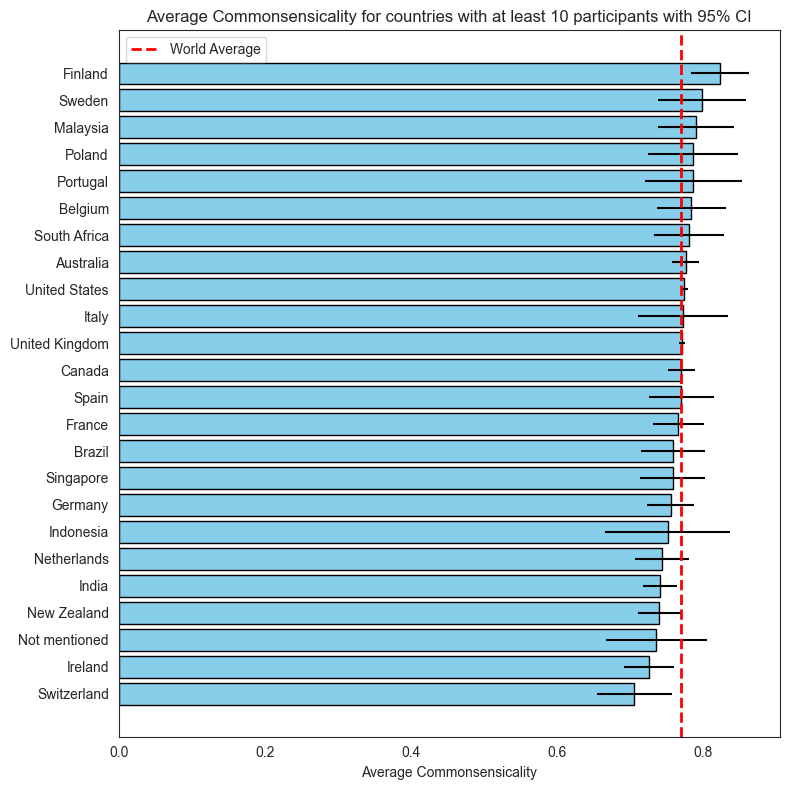

In [ ]:
pandas_df_commonsense_country_info = df_commonsense_country_info.to_pandas()

world_avg = df_commonsense_country_info["commonsensicality"].mean()

grouped = (
    pandas_df_commonsense_country_info.groupby("country_reside")["commonsensicality"]
    .agg(["mean", "std", "count"])
    .reset_index()
)
grouped.rename(columns={"mean": "avg_commonsensicality"}, inplace=True)

# remove countries with less than 2 participants
grouped = grouped[grouped["count"] >= 10]

grouped["ci"] = 1.96 * grouped["std"] / np.sqrt(grouped["count"])

grouped_sorted = grouped.sort_values("avg_commonsensicality", ascending=True)

plt.figure(figsize=(8, 8))
plt.barh(
    grouped_sorted["country_reside"],
    grouped_sorted["avg_commonsensicality"],
    xerr=grouped_sorted["ci"],
    color="skyblue",
    edgecolor="black",
)

plt.axvline(
    x=world_avg, color="red", linestyle="--", linewidth=2, label="World Average"
)

plt.xlabel("Average Commonsensicality")
plt.title("Average Commonsensicality for countries with at least 10 participants with 95% CI")
plt.legend()
plt.tight_layout()
plt.savefig("average_commonsensicality_by_country.pdf", dpi=300, bbox_inches="tight")

Bootstrap 50 people from each country with replacement 100 times 

distribution plot of commonsensicality by country



In [ ]:
df = df_commonsense_country_info.to_pandas()

United Kingdom
United States
Australia
Canada
India


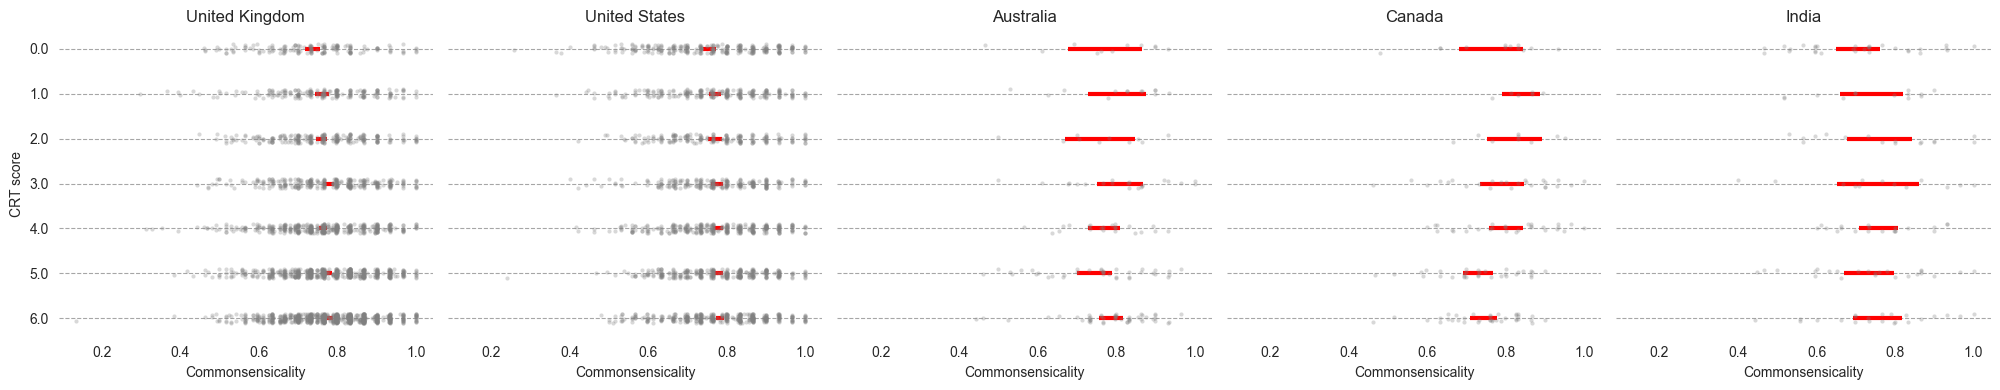

In [ ]:
from scipy import stats


country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()

df_filtered = df[df["country_reside"].isin(valid_countries)]


g = sns.FacetGrid(
    df_filtered,
    col="country_reside",
    col_wrap=6,
    sharex=True,
    sharey=True,
    height=4,
    col_order=valid_countries,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="crt_score",
    color="gray",
    alpha=0.3,
    size=3,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "CRT score")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="y", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        country = title.split(" = ")[-1].strip()
    else:
        country = title

    print(country)
    ax.set_title(country)

    sub_df = df_filtered[df_filtered["country_reside"] == country]

    stats_df = (
        sub_df.groupby("crt_score")["commonsensicality"]
        .agg(["mean", "std", "count"])
        .reset_index()
    )

    stats_df["sem"] = stats_df["std"] / np.sqrt(stats_df["count"])
    stats_df["ci"] = stats_df.apply(
        lambda row: (
            row["sem"] * stats.t.ppf((1 + 0.95) / 2.0, row["count"] - 1)
            if row["count"] > 1
            else 0
        ),
        axis=1,
    )

    ax.hlines(
        y=stats_df["crt_score"],
        xmin=stats_df["mean"] - stats_df["ci"],
        xmax=stats_df["mean"] + stats_df["ci"],
        colors="red",
        linestyles="solid",
        linewidth=3,
    )

plt.tight_layout()
plt.show()

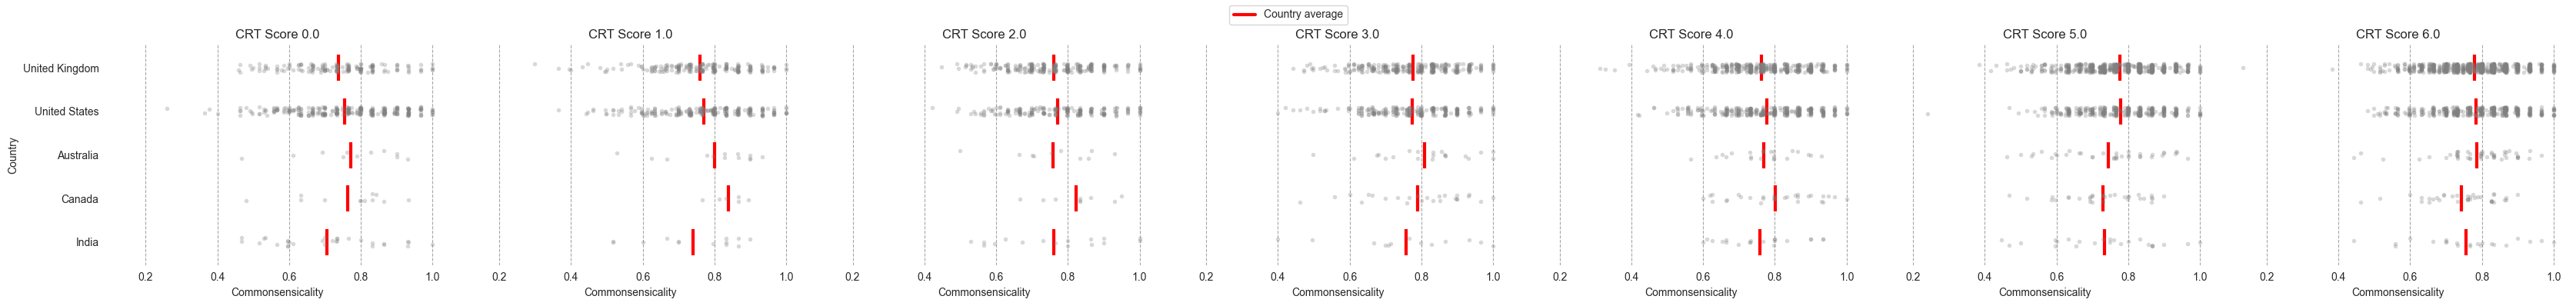

In [ ]:
from matplotlib.lines import Line2D


country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["crt_score"])


sorted_crt = sorted(df_filtered["crt_score"].unique())


overall_common = df_filtered["commonsensicality"].mean()


g = sns.FacetGrid(
    df_filtered,
    col="crt_score",
    col_order=sorted_crt,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        crt_val = title.split("=")[-1].strip()
    else:
        crt_val = title
    ax.set_title(f"CRT Score {crt_val}")

    sub_df = df_filtered[df_filtered["crt_score"] == float(crt_val)]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:
            y_pos = valid_countries.index(country)

            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "average_commonsensicality_by_country_crt.pdf", dpi=300, bbox_inches="tight"
)

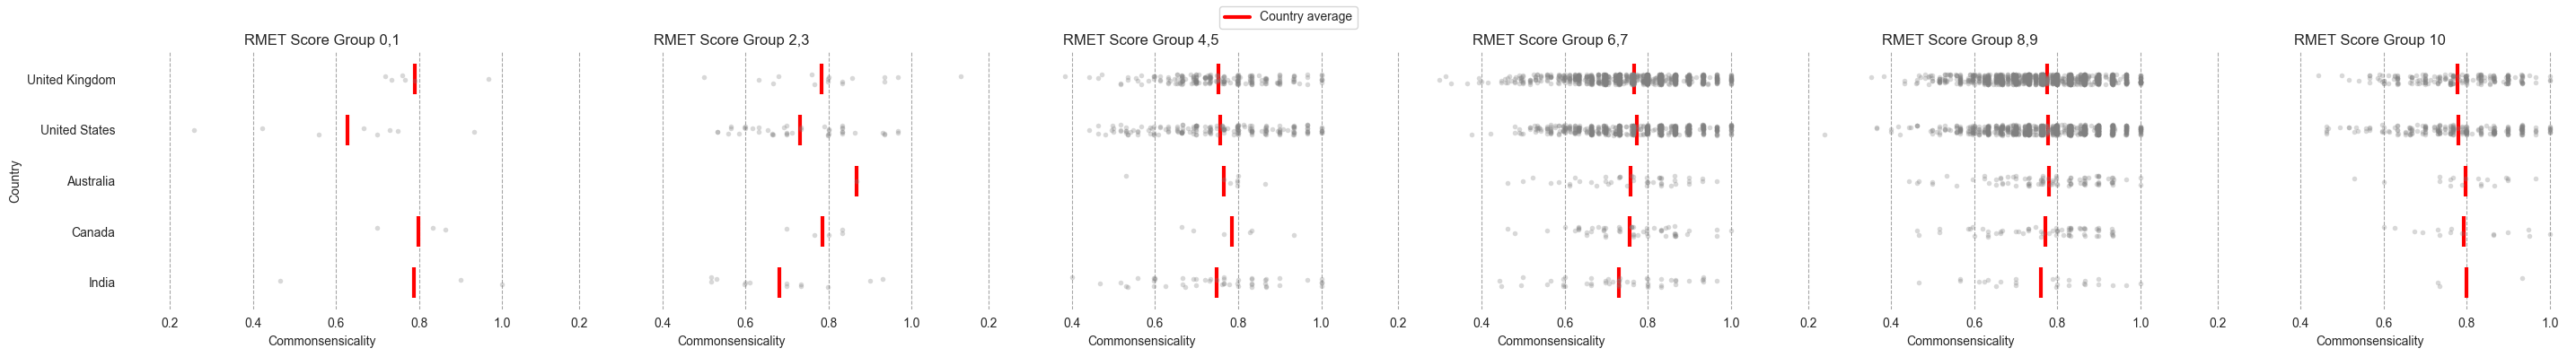

In [ ]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["rmeTen_score"])

bins = [-0.5, 1.5, 3.5, 5.5, 7.5, 9.5, 10.5]
labels = ["0,1", "2,3", "4,5", "6,7", "8,9", "10"]
df_filtered["rmet_group"] = pd.cut(
    df_filtered["rmeTen_score"], bins=bins, labels=labels, include_lowest=True
)


sorted_rmet = labels


g = sns.FacetGrid(
    df_filtered,
    col="rmet_group",
    col_order=sorted_rmet,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        group_val = title.split("=")[-1].strip()
    else:
        group_val = title
    ax.set_title(f"RMET Score Group {group_val}")

    sub_df = df_filtered[df_filtered["rmet_group"] == group_val]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:
            y_pos = valid_countries.index(country)
            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "average_commonsensicality_by_country_rmet_group.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

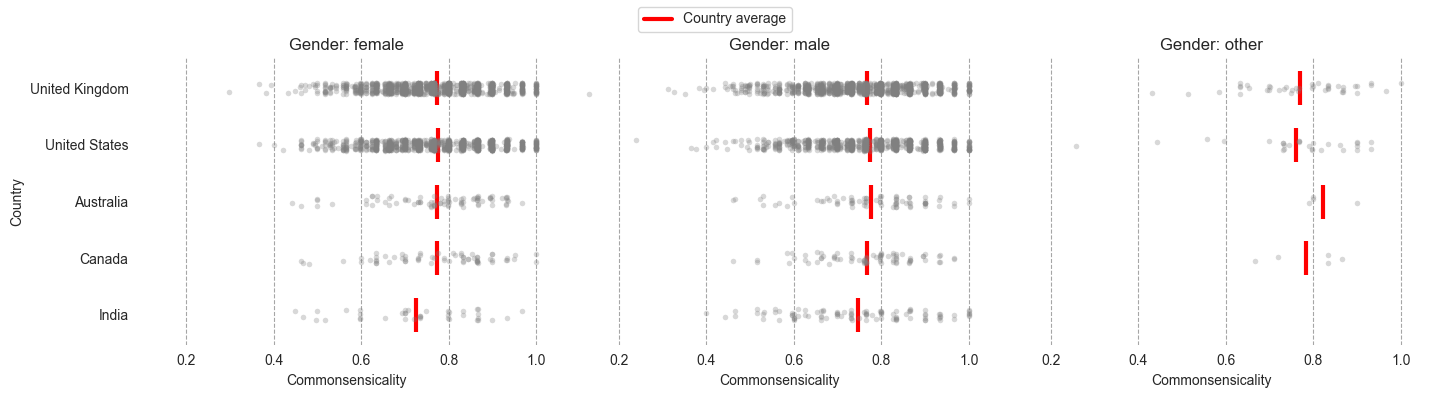

In [ ]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["gender"])


sorted_gender = sorted(df_filtered["gender"].unique())


overall_common = df_filtered["commonsensicality"].mean()


g = sns.FacetGrid(
    df_filtered,
    col="gender",
    col_order=sorted_gender,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        gender_val = title.split("=")[-1].strip()
    else:
        gender_val = title
    ax.set_title(f"Gender: {gender_val}")

    sub_df = df_filtered[df_filtered["gender"] == gender_val]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:

            y_pos = valid_countries.index(country)
            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "average_commonsensicality_by_country_gender.pdf", dpi=300, bbox_inches="tight"
)
plt.show()

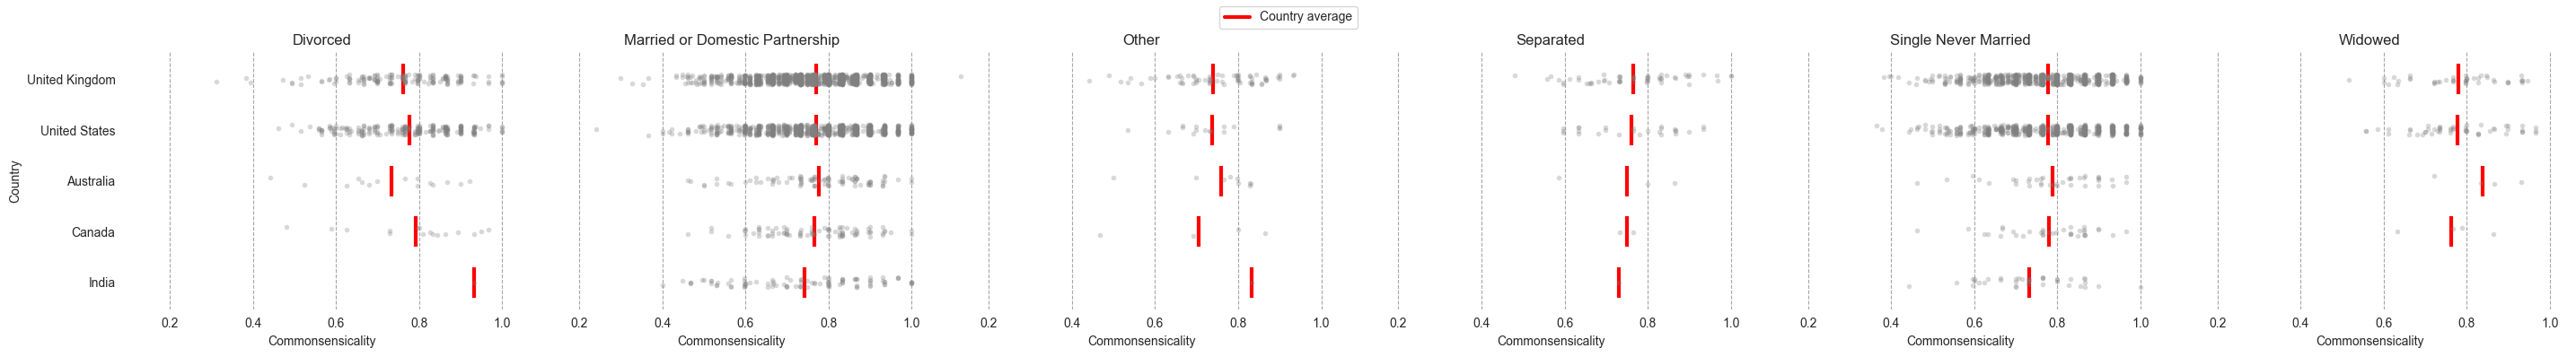

In [ ]:
country_counts = df["country_reside"].value_counts()
valid_countries = country_counts[country_counts > 60].index.tolist()
df_filtered = df[df["country_reside"].isin(valid_countries)]
df_filtered = df_filtered.dropna(subset=["marital_status"])


sorted_marital_status = sorted(df_filtered["marital_status"].unique())


overall_common = df_filtered["commonsensicality"].mean()


g = sns.FacetGrid(
    df_filtered,
    col="marital_status",
    col_order=sorted_marital_status,
    sharex=True,
    sharey=True,
    height=4,
    aspect=1.2,
)


g.map_dataframe(
    sns.stripplot,
    x="commonsensicality",
    y="country_reside",
    order=valid_countries,
    color="gray",
    alpha=0.3,
    size=4,
    orient="h",
)

g.set_axis_labels("Commonsensicality", "Country")


for ax in g.axes.flat:

    for spine in ax.spines.values():
        spine.set_visible(False)
    ax.grid(axis="x", linestyle="--", color="gray", alpha=0.7)

    title = ax.get_title()
    if "=" in title:
        marital_status_val = title.split("=")[-1].strip()
    else:
        marital_status_val = title
    ax.set_title(f"{marital_status_val}")

    sub_df = df_filtered[df_filtered["marital_status"] == marital_status_val]

    stats_df = (
        sub_df.groupby("country_reside")["commonsensicality"].mean().reset_index()
    )

    for _, row in stats_df.iterrows():
        country = row["country_reside"]
        mean_val = row["commonsensicality"]
        if country in valid_countries:

            y_pos = valid_countries.index(country)
            delta = 0.3
            ax.vlines(
                x=mean_val,
                ymin=y_pos - delta,
                ymax=y_pos + delta,
                colors="red",
                linewidth=3,
            )


legend_handles = [
    Line2D([], [], color="red", linestyle="-", linewidth=3, label="Country average")
]
plt.figlegend(handles=legend_handles, loc="upper center", ncol=1, frameon=True)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(
    "average_commonsensicality_by_country_marital_status.pdf",
    dpi=300,
    bbox_inches="tight",
)
plt.show()

In [ ]:
# predict commonsensicality based on country and other demographics

In [ ]:
from scipy.stats import f_oneway

df_group = df_commonsense_country_info.to_pandas()
groups = [group["commonsensicality"].dropna() for name, group in df_group.groupby("country_reside")]

In [ ]:
groups = [group for group in groups if len(group) > 10]

In [ ]:
F, p_value = f_oneway(*groups)
print("ANOVA F-statistic:", F)
print("ANOVA p-value:", p_value)

ANOVA F-statistic: 1.5883783671873986
ANOVA p-value: 0.03968524092076304


In [ ]:
df_commonsense_country_info.head(3)

userSessionId,CRT,rmeTen,demographics,demographicsLongInternational,crt_score,rmeTen_score,birth_year,gender,marital_status,language_primary,english_written,english_spoken,employment_status,country_reside,education_US,latin_US,race_US,income_US,consensus,awareness,response_count,commonsensicality
str,str,str,str,str,f64,f64,str,str,str,str,i64,i64,str,str,str,str,list[str],str,f64,f64,u32,f64
"""LBXcpSd4QDYBieK1N3-2HaiZBkt5p4…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,5.0,8.0,"""1986""","""male""","""Single Never Married""","""English""",5,5,"""Employed for wages""","""United Kingdom""",null,null,[],null,0.666667,0.933333,15,0.788811
"""DcrgJQK7FX5UZZUtqeT1IZwgwxEpAj…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,0.0,5.0,"""1982""","""male""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""India""",null,null,[],null,0.466667,0.466667,15,0.466667
"""coaErO8h2OEH4IeSyLU7oczW9f_XCu…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…","""{""surveySource"":""@watts-lab/su…",null,5.0,10.0,"""1979""","""female""","""Married or Domestic Partnershi…","""English""",5,5,"""Employed for wages""","""United Kingdom""",null,null,[],null,0.6,0.666667,15,0.632456


In [ ]:
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_text
from sklearn.model_selection import train_test_split


df_pd = df_commonsense_country_info.to_pandas()

# Define the target and features.
target = "commonsensicality"
features = [
    "gender",
    "crt_score",
    "rmeTen_score",
    # "marital_status",
    # "language_primary",
    # "english_written",
    # "english_spoken",
    # "employment_status",
]

X = df_pd[features]
y = df_pd[target]


categorical_features = [
    "gender",
    # "marital_status",
    # "language_primary",
    # "employment_status",
]


X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)


X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.2, random_state=42
)


reg_tree = DecisionTreeRegressor(random_state=42)
reg_tree.fit(X_train, y_train)


score = reg_tree.score(X_test, y_test)
print("R^2 Score on test data:", score)


tree_rules = export_text(reg_tree, feature_names=list(X_encoded.columns))
print("\nDecision Tree Rules:\n", tree_rules)

R^2 Score on test data: -0.05822833298467622

Decision Tree Rules:
 |--- crt_score <= 0.50
|   |--- rmeTen_score <= 3.50
|   |   |--- gender_other <= 0.50
|   |   |   |--- rmeTen_score <= 2.50
|   |   |   |   |--- rmeTen_score <= 0.50
|   |   |   |   |   |--- gender_male <= 0.50
|   |   |   |   |   |   |--- value: [0.73]
|   |   |   |   |   |--- gender_male >  0.50
|   |   |   |   |   |   |--- value: [0.79]
|   |   |   |   |--- rmeTen_score >  0.50
|   |   |   |   |   |--- gender_male <= 0.50
|   |   |   |   |   |   |--- rmeTen_score <= 1.50
|   |   |   |   |   |   |   |--- value: [0.62]
|   |   |   |   |   |   |--- rmeTen_score >  1.50
|   |   |   |   |   |   |   |--- value: [0.77]
|   |   |   |   |   |--- gender_male >  0.50
|   |   |   |   |   |   |--- rmeTen_score <= 1.50
|   |   |   |   |   |   |   |--- value: [0.93]
|   |   |   |   |   |   |--- rmeTen_score >  1.50
|   |   |   |   |   |   |   |--- value: [0.68]
|   |   |   |--- rmeTen_score >  2.50
|   |   |   |   |--- gender_mal

In [162]:
# from sklearn.tree import plot_tree


# plt.figure(figsize=(20, 10))

# plot_tree(reg_tree, feature_names=list(X_encoded.columns), filled=True)
# plt.title("Regression Tree for 'commonsensicality'")
# plt.show()